## Used kernels
 https://www.kaggle.com/mathormad/aptos-resnet50-baseline/data

 https://www.kaggle.com/ratthachat/aptos-simple-preprocessing-decoloring-cropping
 
 https://www.kaggle.com/xhlulu/aptos-2019-densenet-keras-starter/output#data
 
 https://www.kaggle.com/joorarkesteijn/fast-cropping-preprocessing-and-augmentation

In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import cv2
from PIL import Image
from tqdm import tqdm
from keras.layers import Input, Dense, Conv2D, Flatten, GaussianDropout, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.losses import binary_crossentropy, categorical_crossentropy
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from keras.callbacks import Callback
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from keras.callbacks import (Callback, ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau,CSVLogger)

In [20]:
print(os.listdir("../input/pretrain-aptos"))

['xception_bestqwk.h5']


In [21]:
TRAIN_DIR = '../input/aptos2019-blindness-detection'
IMAGE_DIR_TRAIN = TRAIN_DIR + '/train_images/'
IMAGE_DIR_TEST = TRAIN_DIR + '/test_images/'
RANDOM_STATE = 42
BATCH_SIZE = 32
NUM_CLASSES = 5
SIZE = 299
TEST_RATIO = 0.15

In [22]:
def crop_image1(img,tol=7):        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [23]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=True):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - SIZE/2
    M[1,2] -= cy - SIZE/2
    return cv2.warpAffine(im,M,(SIZE,SIZE)) # This is the most important line

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def path_to_image(img_path, resize=True, augmentation=False, subtract_gaussian=False, subtract_median=False):
    im = cv2.imread(img_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if resize_image:
        im = resize_image(im, augmentation)
    if subtract_gaussian:
        im = subtract_gaussian_bg_image(im)
    if subtract_median:
        im = subtract_median_bg_image(im)
    return im

In [24]:
data = pd.read_csv(TRAIN_DIR + '/train.csv')
test = pd.read_csv(TRAIN_DIR + '/test.csv')

In [25]:
N = data.shape[0]
train = np.empty((N, SIZE, SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(data['id_code'])):
    train[i, :, :, :] = path_to_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 3662/3662 [04:22<00:00, 13.54it/s]


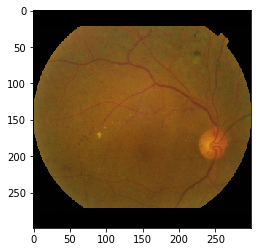

In [26]:
plt.imshow(train[5,:,:,:])

In [27]:
y = data['diagnosis']
y = to_categorical(y, num_classes=NUM_CLASSES)
train_x, test_x, train_y, test_y = train_test_split(train, y, test_size=TEST_RATIO, random_state=RANDOM_STATE)
train_x, train_y = shuffle(train_x, train_y, random_state=RANDOM_STATE)

In [28]:
def cohen_ks(true, pred):
    return cohen_kappa_score(true, pred, labels=[0,1,2,3,4], weights='quadratic')

In [29]:
def kappa_loss(y_pred, y_true, y_pow=2, eps=1e-10, N=5, bsize=256, name='kappa'):
    """A continuous differentiable approximation of discrete kappa loss.
        Args:
            y_pred: 2D tensor or array, [batch_size, num_classes]
            y_true: 2D tensor or array,[batch_size, num_classes]
            y_pow: int,  e.g. y_pow=2
            N: typically num_classes of the model
            bsize: batch_size of the training or validation ops
            eps: a float, prevents divide by zero
            name: Optional scope/name for op_scope.
        Returns:
            A tensor with the kappa loss."""

    with tf.name_scope(name):
        y_true = tf.to_float(y_true)
        repeat_op = tf.to_float(tf.tile(tf.reshape(tf.range(0, N), [N, 1]), [1, N]))
        repeat_op_sq = tf.square((repeat_op - tf.transpose(repeat_op)))
        weights = repeat_op_sq / tf.to_float((N - 1) ** 2)
    
        pred_ = y_pred ** y_pow
        try:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [-1, 1]))
        except Exception:
            pred_norm = pred_ / (eps + tf.reshape(tf.reduce_sum(pred_, 1), [bsize, 1]))
    
        hist_rater_a = tf.reduce_sum(pred_norm, 0)
        hist_rater_b = tf.reduce_sum(y_true, 0)
    
        conf_mat = tf.matmul(tf.transpose(pred_norm), y_true)
    
        nom = tf.reduce_sum(weights * conf_mat)
        denom = tf.reduce_sum(weights * tf.matmul(
            tf.reshape(hist_rater_a, [N, 1]), tf.reshape(hist_rater_b, [1, N])) /
                              tf.to_float(bsize))
    
        return nom / (denom + eps)

In [38]:
def create_model_xception(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Xception(include_top=False,
                   weights=None,
                   input_tensor=input_tensor)
    #base_model.load_weights('../input/pretrain-aptos/xception_bestqwk.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    model.load_weights('../input/pretrain-aptos/xception_bestqwk.h5')
    
    return model
model = create_model_xception((SIZE,SIZE,3), 5)
model.compile(Adam(1e-5), loss=kappa_loss,metrics=['accuracy' ])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [31]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                #X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [32]:
class Metrics2(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def flatten(self, y):
        return np.argmax(y, axis=1).reshape(-1)
    
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)  
        _val_kappa = cohen_kappa_score(self.flatten(y_val), self.flatten(y_pred), weights='quadratic', labels=[0,1,2,3,4])
        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}") 
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')
        return

In [37]:
csv_logger = CSVLogger(filename='../working/training_log.csv',
                       separator=',',
                       append=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='min', min_delta=0.0001)

In [33]:
data_generator = ImageDataGenerator(zoom_range=0.15, fill_mode='constant', cval=0., horizontal_flip=True, vertical_flip=True)
train_generated = data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
val_generated = data_generator.flow(test_x, test_y, batch_size=BATCH_SIZE)
mixup_generator = MixupGenerator(train_x, train_y, batch_size=BATCH_SIZE, alpha=0.2, datagen=data_generator)()

In [ ]:
history = model.fit_generator(
    mixup_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=train_x.shape[0] / BATCH_SIZE,
    epochs=15,
    callbacks=[Metrics2(), csv_logger, reduceLROnPlat])

In [ ]:
submit = pd. read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
predicted = []

In [ ]:
model.load_weights('model.h5')
for i, name in tqdm(enumerate(submit['id_code'])):
    path = os.path.join(IMAGE_DIR_TEST, name+'.png')
    image = preprocess_image(path)
    score_predict = model.predict((image[np.newaxis]))
    label_predict = np.argmax(score_predict)
    predicted.append(str(label_predict))

In [ ]:
submit['diagnosis'] = predicted
submit.to_csv('submission.csv', index=False)
submit.head()